In [1]:
#accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import dask_ndfilters
# How about visualization?
%matplotlib inline
from xmovie import Movie
import xrscipy.signal as dsp
import xrft
import scipy.signal as scp
import netCDF4
import xgcm
from netCDF4 import Dataset
import time as tm
from xmitgcm import open_mdsdataset
import time as tm
import pylab as plt
from llcmap_bi_split import LLCMap_bi_split
from face_connections import face_connections
from llcmap_nea_split import LLCMap_nea_split
from timeline_MITgcm import timeline
from datetime import datetime, timedelta
import importlib
from GetNCDataSet import getMITNCDataSet
from MIT_xr_cwt_dateloc_fol import loadMITData
from MITllc2160Depth import *


from dask.distributed import Client
client = Client(memory_limit='90GB',n_workers = 40, threads_per_worker=1)

In [ ]:
# good - now, let me make a bunch of .nc files:
fol = "/nobackup/amondal/NCData/20210928_GEOS_tend_test/TA"
VAR = "Theta"
firstlevel = 0
finallevel = 22
theta = getNCDataSet(fol,VAR, firstlevel,finallevel)

As it turns out, GEOS data gets organized differently to the MIT data. So I need to figure out how to pull that data. 

In [2]:
lat_out = np.arange(-90,90, 0.0625)
lon_out = np.arange(0, 360,0.0625)
output=xr.DataArray(np.zeros((lat_out.shape[0], lon_out.shape[0])), coords=[lat_out, lon_out], dims = ['lat', 'lon'])
output2 = xr.DataArray(np.zeros((lat_out.shape[0], lon_out.shape[0])), coords = [lat_out, lon_out], dims = ['lat', 'lon'])
GEOS_gridfile = "/nobackupp11/dmenemen/DYAMOND/c1440_llc2160/GEOS_6km_Atmosphere-MITgcm_4km_Ocean-Coupled/GEOSgcm_output/grid_coordinates/geos_c1440_lat_lon.nc"
gridds = xr.open_mfdataset(GEOS_gridfile)
XC = gridds.lon
YC = gridds.lat
print(XC.shape)
print(YC.shape)


(8640, 1440)
(8640, 1440)


##### XC

In [3]:
gridds = gridds.compute()

------------------------------------------------------
Here's the fixed grid that you need to be looking at!

In [4]:
GEOS_test = "/nobackupp2/estrobac/geos5/c1440_llc2160_04/holding/geosgcm_surf/c1440_llc2160_04.geosgcm_surf.20120603_0600z.nc4"
gridFix = xr.open_dataset(GEOS_test)

In [15]:
gridFix

<xarray.Dataset>
Dimensions:       (Xdim: 1440, Ydim: 1440, ncontact: 4, nf: 6, time: 1)
Coordinates:
  * nf            (nf) int32 1 2 3 4 5 6
  * ncontact      (ncontact) int32 1 2 3 4
  * Xdim          (Xdim) float64 -54.97 -54.92 -54.87 ... 34.87 34.92 34.97
  * Ydim          (Ydim) float64 -44.97 -44.92 -44.87 ... 44.87 44.92 44.97
    lons          (nf, Ydim, Xdim) float64 ...
    lats          (nf, Ydim, Xdim) float64 ...
  * time          (time) datetime64[ns] 2012-06-03T06:00:00
Data variables: (12/152)
    cubed_sphere  |S1 ...
    contacts      (nf, ncontact) int32 ...
    orientation   (nf, ncontact) |S5 ...
    anchor        (nf, ncontact, ncontact) int32 ...
    ALBEDO        (time, nf, Ydim, Xdim) float32 ...
    ALBNF         (time, nf, Ydim, Xdim) float32 ...
    ...            ...
    WET1          (time, nf, Ydim, Xdim) float32 ...
    WET2          (time, nf, Ydim, Xdim) float32 ...
    WET3          (time, nf, Ydim, Xdim) float32 ...
    Z0            (time, nf, Ydim, Xdim) float32 ...
    Z0H           (time, nf, Ydim, Xdim) float32 ...
    ZETA_W        (time, nf, Ydim, Xdim) float32 ...
Attributes:
    History:      File written by MAPL_CFIO
    Source:       Heracles-5_3
    Title:        c1440_llc2160_04
    Contact:      http://gmao.gsfc.nasa.gov
    Conventions:  COARDS
    Institution:  NASA Global Modeling and Assimilation Office
    References:   http://gmao.gsfc.nasa.gov
    Comment:      c1440_llc2160_04

In [5]:
xc = gridFix.lons
yc = gridFix.lats

In [17]:
xc

<xarray.DataArray 'lons' (nf: 6, Ydim: 1440, Xdim: 1440)>
[12441600 values with dtype=float64]
Coordinates:
  * nf       (nf) int32 1 2 3 4 5 6
  * Xdim     (Xdim) float64 -54.97 -54.92 -54.87 -54.82 ... 34.87 34.92 34.97
  * Ydim     (Ydim) float64 -44.97 -44.92 -44.87 -44.82 ... 44.87 44.92 44.97
    lons     (nf, Ydim, Xdim) float64 ...
    lats     (nf, Ydim, Xdim) float64 ...
Attributes:
    long_name:  longitude
    units:      degrees_east

In [18]:
gridNC = Dataset(GEOS_gridfile)

In [19]:
latg = gridNC.variables['lat'][:]

In [20]:
latg.shape

(8640, 1440)

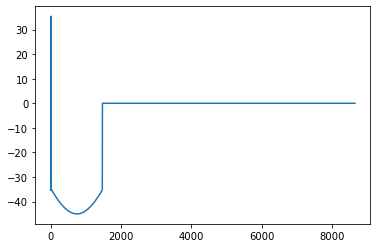

In [21]:
%matplotlib inline
plt.plot(latg[:,1439])

In [22]:
gridds

<xarray.Dataset>
Dimensions:  (Xdim: 1440, Ydim: 8640)
Dimensions without coordinates: Xdim, Ydim
Data variables:
    lat      (Ydim, Xdim) float64 dask.array<chunksize=(8640, 1440), meta=np.ndarray>
    lon      (Ydim, Xdim) float64 dask.array<chunksize=(8640, 1440), meta=np.ndarray>

In [23]:
gridc

NameError: name 'gridc' is not defined

In [7]:
gridc = gridds.compute()
XC = gridc.lon
YC = gridc.lat

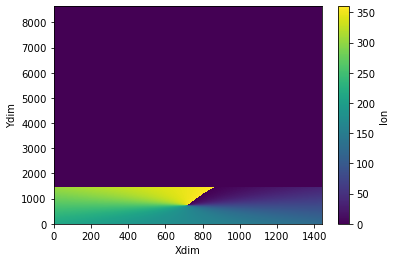

In [8]:
%matplotlib inline
XC.plot()

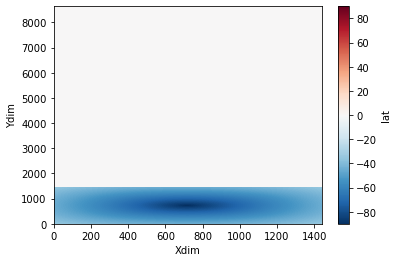

In [9]:
%matplotlib inline
YC.plot()

In [27]:
np.max(YC)

<xarray.DataArray 'lat' ()>
array(45.28619385)

In [28]:
np.min(YC)

<xarray.DataArray 'lat' ()>
array(-89.95101929)

In [29]:
np.min(XC)

<xarray.DataArray 'lon' ()>
array(0.)

In [30]:
np.max(XC)

<xarray.DataArray 'lon' ()>
array(359.99978638)

In [31]:
mapper=LLCMap_nea_split(XC.values,YC.values,lat_out,lon_out,radius=15e3)
mapper2 =LLCMap_nea_split(XC.values, YC.values, lat_out, lon_out, radius = 30e3)

In [32]:
mapper

In [2]:
#Let me open up one of the netcdf4 files that are in Dimitris' directories:
diro = "/nobackupp11/dmenemen/DYAMOND/c1440_llc2160/holding/geosgcm_tend/"
file = "DYAMOND_c1440_llc2160.geosgcm_tend.20200120_0900z.nc4"
gsamp = xr.open_dataset(diro+file)

In [5]:
print(gsamp)

<xarray.Dataset>
Dimensions:   (lat: 8640, lev: 52, lon: 1440, time: 1)
Coordinates:
  * lon       (lon) float64 305.0 305.1 305.1 305.2 ... 34.82 34.87 34.92 34.97
  * lat       (lat) float64 -35.25 -35.2 -35.15 -35.11 ... -35.34 -35.31 -35.29
  * lev       (lev) float64 21.0 22.0 23.0 24.0 25.0 ... 69.0 70.0 71.0 72.0
  * time      (time) datetime64[ns] 2020-01-20T09:00:00
Data variables: (12/20)
    DPDTPHY   (time, lev, lat, lon) float32 ...
    DQVDTCHM  (time, lev, lat, lon) float32 ...
    DQVDTDYN  (time, lev, lat, lon) float32 ...
    DQVDTMST  (time, lev, lat, lon) float32 ...
    DQVDTTRB  (time, lev, lat, lon) float32 ...
    DTDTDYN   (time, lev, lat, lon) float32 ...
    ...        ...
    DUDTMST   (time, lev, lat, lon) float32 ...
    DUDTTRB   (time, lev, lat, lon) float32 ...
    DVDTDYN   (time, lev, lat, lon) float32 ...
    DVDTGWD   (time, lev, lat, lon) float32 ...
    DVDTMST   (time, lev, lat, lon) float32 ...
    DVDTTRB   (time, lev, lat, lon) float32 ...
Att

In [6]:
#output[:] = mapper(gsamp['DTDTDYN'].mean('time').values)
output2[:] = mapper2(gsamp['DTDTDYN'].isel(lev = 0).mean('time').values)

NameError: name 'mapper2' is not defined

In [36]:
dtdtdyn = gsamp['DTDTDYN']

In [37]:
dtdtdyn

<xarray.DataArray 'DTDTDYN' (time: 1, lev: 52, lat: 8640, lon: 1440)>
[646963200 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 305.0 305.1 305.1 305.2 ... 34.82 34.87 34.92 34.97
  * lat      (lat) float64 -35.25 -35.2 -35.15 -35.11 ... -35.34 -35.31 -35.29
  * lev      (lev) float64 21.0 22.0 23.0 24.0 25.0 ... 68.0 69.0 70.0 71.0 72.0
  * time     (time) datetime64[ns] 2020-01-20T09:00:00
Attributes:
    long_name:       tendency_of_air_temperature_due_to_dynamics
    units:           K s-1
    fmissing_value:  1000000000000000.0
    standard_name:   tendency_of_air_temperature_due_to_dynamics
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

In [38]:
dtdtdynONE = dtdtdyn.isel(lev =51 )

In [39]:
dtdtdynONE.size

12441600

In [40]:
output[:] = mapper(dtdtdynONE.mean('time').values)

In [41]:
output.size

16588800

In [42]:
output.sel(lon = 0)

<xarray.DataArray (lat: 2880)>
array([            nan,             nan,             nan, ...,
       -6.41489896e-06,  1.62893375e-05,  6.60815494e-05])
Coordinates:
  * lat      (lat) float64 -90.0 -89.94 -89.88 -89.81 ... 89.81 89.88 89.94
    lon      float64 0.0

In [43]:
subset = output.values

In [44]:
subset[750:]

array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       ...,
       [-6.41489896e-06,  7.69648323e-05,  7.69648323e-05, ...,
                    nan,             nan,             nan],
       [ 1.62893375e-05,  6.92801332e-05,  6.92801332e-05, ...,
                    nan,             nan,             nan],
       [ 6.60815494e-05,  6.60815494e-05,  6.60815494e-05, ...,
                    nan,             nan,             nan]])

In [45]:
output2.size

16588800

In [46]:
non_nans = (~np.isnan(output.values)).sum()

In [47]:
non_nans

33070

In [48]:
non_nans2 = (~np.isnan(output2.values)).sum()

In [49]:
non_nans2

58213

The conclusion from the above work is that the grid included in the DYAMOND directories is missing 5/6 of the coordinates necessary for interpolation. There are coordinates in Udi's old files that I can use instead. I just have to rearrange the arrays so that they are in (8640,1440) format instead of (6,1440,1440) format.

In [11]:
gridFix

<xarray.Dataset>
Dimensions:       (Xdim: 1440, Ydim: 1440, ncontact: 4, nf: 6, time: 1)
Coordinates:
  * nf            (nf) int32 1 2 3 4 5 6
  * ncontact      (ncontact) int32 1 2 3 4
  * Xdim          (Xdim) float64 -54.97 -54.92 -54.87 ... 34.87 34.92 34.97
  * Ydim          (Ydim) float64 -44.97 -44.92 -44.87 ... 44.87 44.92 44.97
    lons          (nf, Ydim, Xdim) float64 ...
    lats          (nf, Ydim, Xdim) float64 ...
  * time          (time) datetime64[ns] 2012-06-03T06:00:00
Data variables: (12/152)
    cubed_sphere  |S1 ...
    contacts      (nf, ncontact) int32 ...
    orientation   (nf, ncontact) |S5 ...
    anchor        (nf, ncontact, ncontact) int32 ...
    ALBEDO        (time, nf, Ydim, Xdim) float32 ...
    ALBNF         (time, nf, Ydim, Xdim) float32 ...
    ...            ...
    WET1          (time, nf, Ydim, Xdim) float32 ...
    WET2          (time, nf, Ydim, Xdim) float32 ...
    WET3          (time, nf, Ydim, Xdim) float32 ...
    Z0            (time, nf, Ydim, Xdim) float32 ...
    Z0H           (time, nf, Ydim, Xdim) float32 ...
    ZETA_W        (time, nf, Ydim, Xdim) float32 ...
Attributes:
    History:      File written by MAPL_CFIO
    Source:       Heracles-5_3
    Title:        c1440_llc2160_04
    Contact:      http://gmao.gsfc.nasa.gov
    Conventions:  COARDS
    Institution:  NASA Global Modeling and Assimilation Office
    References:   http://gmao.gsfc.nasa.gov
    Comment:      c1440_llc2160_04

In [8]:
lons = gridFix.lons
lats = gridFix.lats

In [14]:
lons

<xarray.DataArray 'lons' (nf: 6, Ydim: 1440, Xdim: 1440)>
[12441600 values with dtype=float64]
Coordinates:
  * nf       (nf) int32 1 2 3 4 5 6
  * Xdim     (Xdim) float64 -54.97 -54.92 -54.87 -54.82 ... 34.87 34.92 34.97
  * Ydim     (Ydim) float64 -44.97 -44.92 -44.87 -44.82 ... 44.87 44.92 44.97
    lons     (nf, Ydim, Xdim) float64 ...
    lats     (nf, Ydim, Xdim) float64 ...
Attributes:
    long_name:  longitude
    units:      degrees_east

In [15]:
lons.isel(nf=0)

<xarray.DataArray 'lons' (Ydim: 1440, Xdim: 1440)>
[2073600 values with dtype=float64]
Coordinates:
    nf       int32 1
  * Xdim     (Xdim) float64 -54.97 -54.92 -54.87 -54.82 ... 34.87 34.92 34.97
  * Ydim     (Ydim) float64 -44.97 -44.92 -44.87 -44.82 ... 44.87 44.92 44.97
    lons     (Ydim, Xdim) float64 ...
    lats     (Ydim, Xdim) float64 ...
Attributes:
    long_name:  longitude
    units:      degrees_east

In [16]:
lons.isel(nf=1)

<xarray.DataArray 'lons' (Ydim: 1440, Xdim: 1440)>
[2073600 values with dtype=float64]
Coordinates:
    nf       int32 2
  * Xdim     (Xdim) float64 -54.97 -54.92 -54.87 -54.82 ... 34.87 34.92 34.97
  * Ydim     (Ydim) float64 -44.97 -44.92 -44.87 -44.82 ... 44.87 44.92 44.97
    lons     (Ydim, Xdim) float64 ...
    lats     (Ydim, Xdim) float64 ...
Attributes:
    long_name:  longitude
    units:      degrees_east

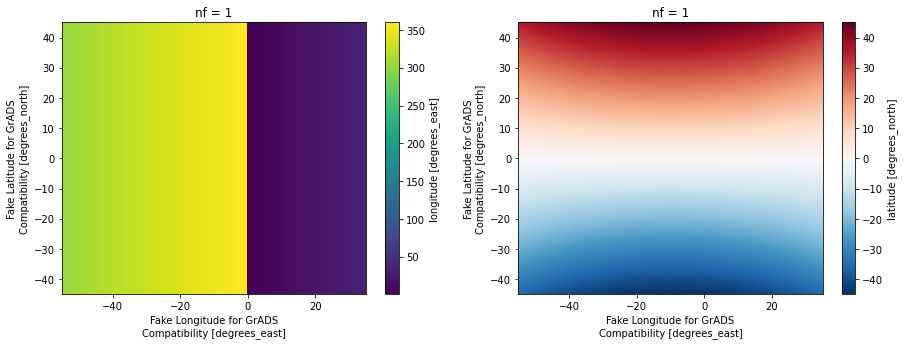

In [10]:
%matplotlib inline
fig, axes = plt.subplots(ncols=2, figsize =[15,5])
axes
lons.isel(nf=0).plot(ax = axes[0])
lats.isel(nf=0).plot(ax = axes[1])

In [11]:
lonslist = np.sort(lons.isel(nf=0).values)
lonslist

array([[2.68389601e-02, 9.50478092e-02, 1.63242429e-01, ...,
        3.59822113e+02, 3.59890381e+02, 3.59958618e+02],
       [2.68389564e-02, 9.50478092e-02, 1.63242429e-01, ...,
        3.59822113e+02, 3.59890381e+02, 3.59958618e+02],
       [2.68389527e-02, 9.50478017e-02, 1.63242429e-01, ...,
        3.59822113e+02, 3.59890381e+02, 3.59958618e+02],
       ...,
       [2.68389527e-02, 9.50478017e-02, 1.63242429e-01, ...,
        3.59822113e+02, 3.59890381e+02, 3.59958618e+02],
       [2.68389564e-02, 9.50478092e-02, 1.63242429e-01, ...,
        3.59822113e+02, 3.59890381e+02, 3.59958618e+02],
       [2.68389601e-02, 9.50478092e-02, 1.63242429e-01, ...,
        3.59822113e+02, 3.59890381e+02, 3.59958618e+02]])

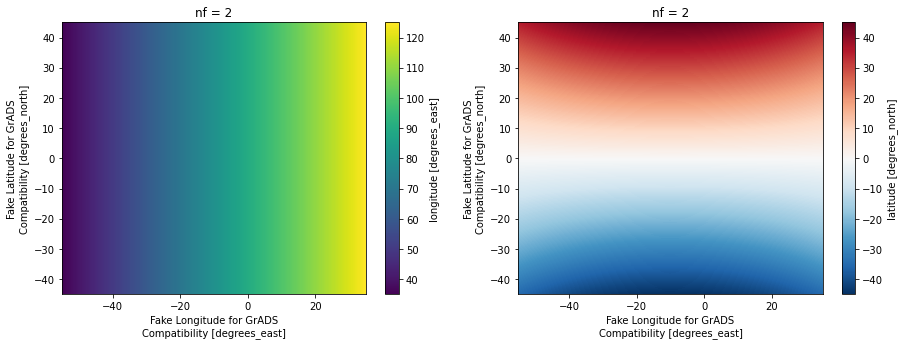

In [12]:
%matplotlib inline
fig, axes = plt.subplots(ncols=2, figsize =[15,5])
axes
lons.isel(nf=1).plot(ax = axes[0])
lats.isel(nf=1).plot(ax = axes[1])

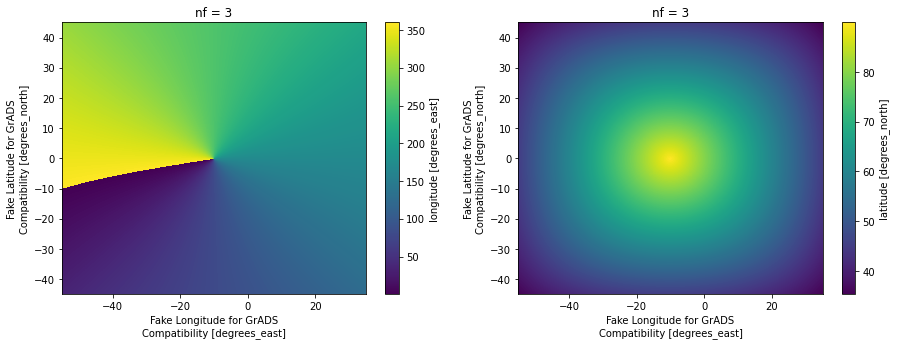

In [13]:
%matplotlib inline
fig, axes = plt.subplots(ncols=2, figsize =[15,5])
axes
lons.isel(nf=2).plot(ax = axes[0])
lats.isel(nf=2).plot(ax = axes[1])

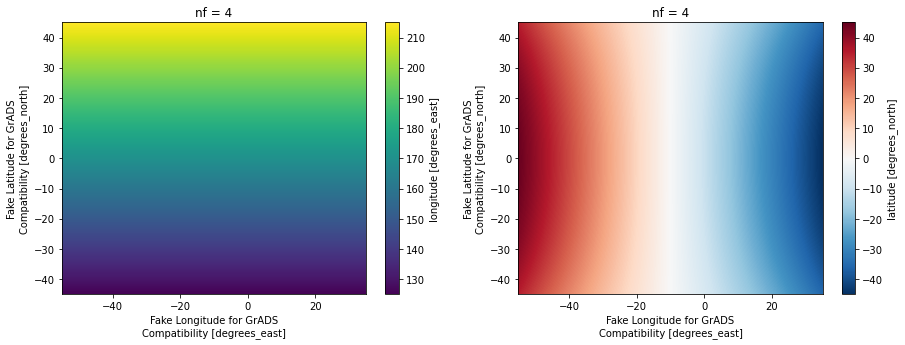

In [14]:
%matplotlib inline
fig, axes = plt.subplots(ncols=2, figsize =[15,5])
axes
lons.isel(nf=3).plot(ax = axes[0])
lats.isel(nf=3).plot(ax = axes[1])

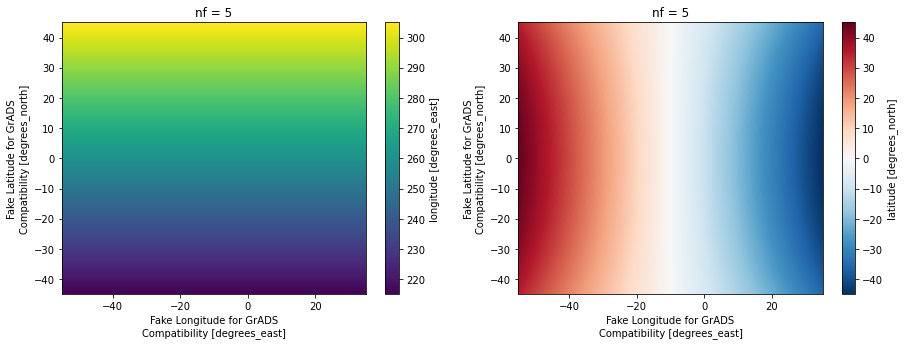

In [22]:
%matplotlib inline
fig, axes = plt.subplots(ncols=2, figsize =[15,5])
axes
lons.isel(nf=4).plot(ax = axes[0])
lats.isel(nf=4).plot(ax = axes[1])

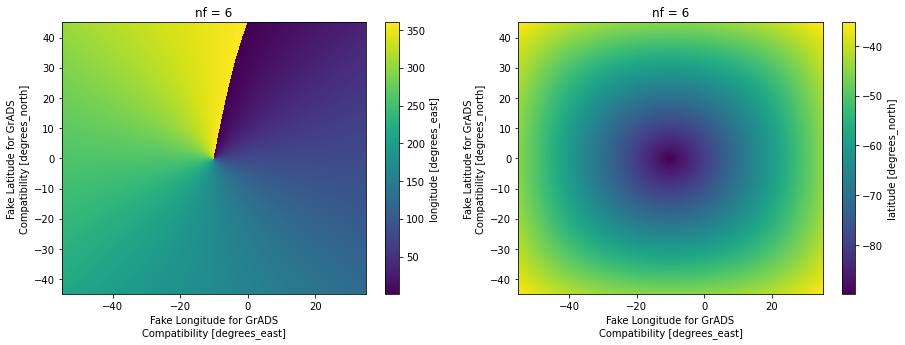

In [15]:
%matplotlib inline
fig, axes = plt.subplots(ncols=2, figsize =[15,5])
axes
lons.isel(nf=5).plot(ax = axes[0])
lats.isel(nf=5).plot(ax = axes[1])

In [ ]:
np.diff(gridFix.Xdim.values)

I need some help organizing GEOS old grid into GEOS new grid

I should be able to just stack these faces together - using rotate if I have to, but I have to find FRocean and FRland to find which face corresponds to which section of the 2D array.

In [16]:
#Let me open up one of the netcdf4 files that are in Dimitris' directories:
diro = "/nobackupp11/dmenemen/DYAMOND/c1440_llc2160/holding/const_2d_asm_Mx/"
file = "DYAMOND_c1440_llc2160.const_2d_asm_Mx.20200122_0000z.nc4"
gsamp = xr.open_dataset(diro+file)

In [26]:
gsamp

<xarray.Dataset>
Dimensions:    (lat: 8640, lon: 1440, time: 1)
Coordinates:
  * lon        (lon) float64 305.0 305.1 305.1 305.2 ... 34.82 34.87 34.92 34.97
  * lat        (lat) float64 -35.25 -35.2 -35.15 -35.11 ... -35.34 -35.31 -35.29
  * time       (time) datetime64[ns] 2020-01-22
Data variables:
    AREA       (time, lat, lon) float32 ...
    FRLAKE     (time, lat, lon) float32 ...
    FRLAND     (time, lat, lon) float32 ...
    FRLANDICE  (time, lat, lon) float32 ...
    FROCEAN    (time, lat, lon) float32 ...
    PHIS       (time, lat, lon) float32 ...
    SGH        (time, lat, lon) float32 ...
Attributes:
    History:      File written by MAPL_CFIO
    Source:       Heracles-5_3
    Title:        2d,Constant,Time-invariant,Cubed-Sphere on Single-Level,Ass...
    Contact:      http://gmao.gsfc.nasa.gov
    Conventions:  COARDS
    Institution:  NASA Global Modeling and Assimilation Office
    References:   http://gmao.gsfc.nasa.gov
    Comment:      DYAMOND_c1440_llc2160

In [19]:
fland = gsamp['FRLAND']

In [20]:
fland

<xarray.DataArray 'FRLAND' (time: 1, lat: 8640, lon: 1440)>
[12441600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 305.0 305.1 305.1 305.2 ... 34.82 34.87 34.92 34.97
  * lat      (lat) float64 -35.25 -35.2 -35.15 -35.11 ... -35.34 -35.31 -35.29
  * time     (time) datetime64[ns] 2020-01-22
Attributes:
    long_name:       fraction_of_land
    units:           1
    fmissing_value:  1000000000000000.0
    standard_name:   fraction_of_land
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

In [29]:
newlats = fland.lat
newlons = fland.lon

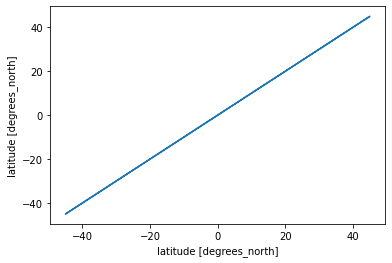

In [30]:
%matplotlib inline
newlats.plot()

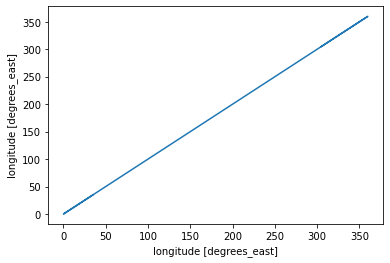

In [31]:
newlons.plot()

In [32]:
%matplotlib inline
fland.isel(time=0)

<xarray.DataArray 'FRLAND' (lat: 8640, lon: 1440)>
[12441600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 305.0 305.1 305.1 305.2 ... 34.82 34.87 34.92 34.97
  * lat      (lat) float64 -35.25 -35.2 -35.15 -35.11 ... -35.34 -35.31 -35.29
    time     datetime64[ns] 2020-01-22
Attributes:
    long_name:       fraction_of_land
    units:           1
    fmissing_value:  1000000000000000.0
    standard_name:   fraction_of_land
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

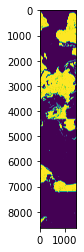

In [33]:
%matplotlib inline
plt.imshow(fland.isel(time=0).values)

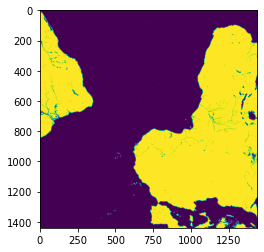

In [34]:
# the first face
%matplotlib inline
plt.imshow(fland[0,0:1440,:].values)

First face looks not only rotated but reflected. So that's fun.

Yup, so the mid Atlantic face needs to contain West Africa. From standard configuration, you flip it and then rotate it 180 degrees.

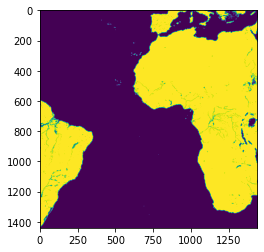

In [35]:
midatlantic_face = fland[0,0:1440,:].values
%matplotlib inline 
plt.imshow(np.flip(np.rot90(midatlantic_face,2),1))

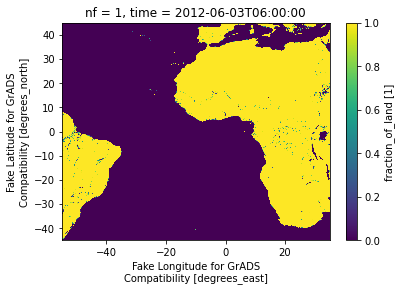

In [36]:
gridFix['FRLAND'].sel(nf=1).plot()

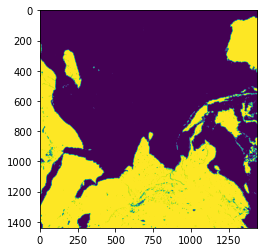

In [37]:
plt.imshow(fland[0,1440:2880,:].values)

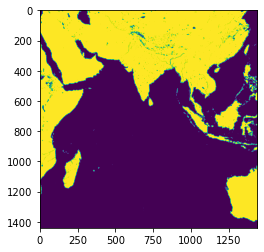

In [38]:
plt.imshow(np.flip(np.rot90(fland[0,1440:2880,:].values,2),1))

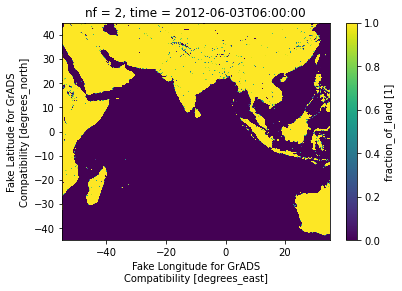

In [39]:
gridFix['FRLAND'].sel(nf=2).plot()

So Indian ocean is rotated twice. And flipped as well.

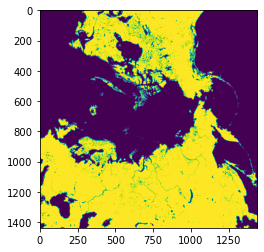

In [40]:
plt.imshow(np.flip(np.rot90(fland[0,2881:4320,:].values,2),1))

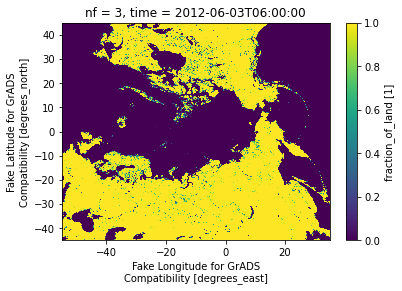

In [41]:
gridFix['FRLAND'].sel(nf=3).plot()

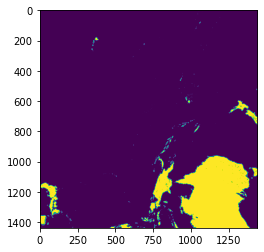

In [42]:
plt.imshow(np.flip(np.rot90(fland[0,4321:5760,:].values,2),1))

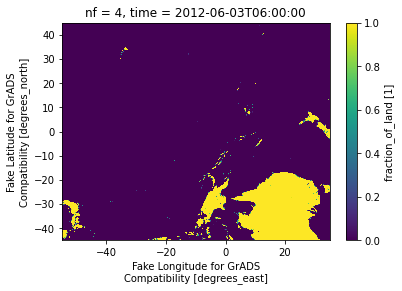

In [43]:
gridFix['FRLAND'].sel(nf=4).plot()

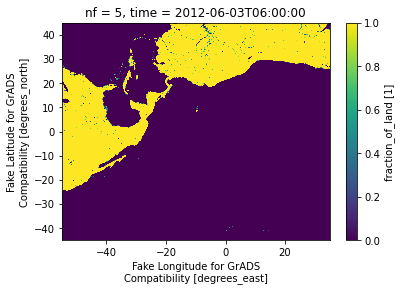

In [44]:
gridFix['FRLAND'].sel(nf=5).plot()

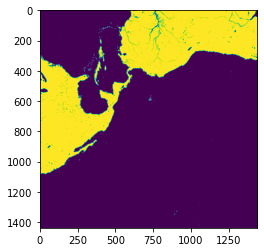

In [45]:
plt.imshow(np.flip(np.rot90(fland[0,5761:7200,:].values,2),1))

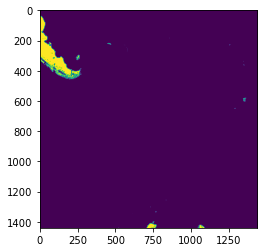

In [46]:
plt.imshow(np.flip(np.rot90(fland[0,7200:8640,:].values,2),1))

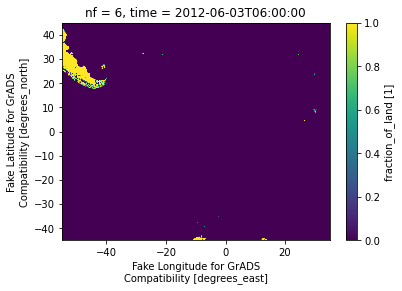

In [47]:
gridFix['FRLAND'].sel(nf=6).plot()

I'll put a few together to see how they "stack up."

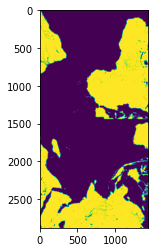

In [21]:
%matplotlib inline
plt.imshow(fland[0, 0:2880,:].values)

In [49]:
fland

<xarray.DataArray 'FRLAND' (time: 1, lat: 8640, lon: 1440)>
[12441600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 305.0 305.1 305.1 305.2 ... 34.82 34.87 34.92 34.97
  * lat      (lat) float64 -35.25 -35.2 -35.15 -35.11 ... -35.34 -35.31 -35.29
  * time     (time) datetime64[ns] 2020-01-22
Attributes:
    long_name:       fraction_of_land
    units:           1
    fmissing_value:  1000000000000000.0
    standard_name:   fraction_of_land
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

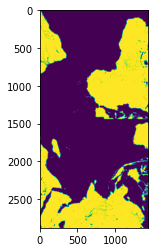

In [50]:
plt.imshow(np.concatenate([gridFix['FRLAND'].isel(time=0, nf = 0).values, gridFix['FRLAND'].isel(time=0, nf= 1).values], 0) )

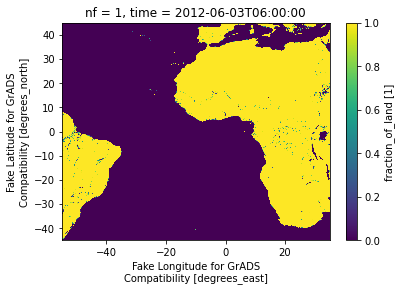

In [51]:
gridFix['FRLAND'].isel(time=0,nf=0).plot()

So it seems like I can do this quite simply!

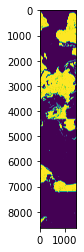

In [17]:
concat_grid = gridFix['FRLAND'].isel(time=0,nf=0).values
for i in range(1,6):
    concat_grid = np.concatenate([concat_grid, gridFix['FRLAND'].isel(time=0, nf=i).values],0)
plt.imshow(concat_grid)

In [18]:
%matplotlib inline
plt.imshow(fland.isel(time=0).values)

NameError: name 'fland' is not defined

In [54]:
fland.lat

<xarray.DataArray 'lat' (lat: 8640)>
array([-35.252136, -35.203152, -35.154167, ..., -35.337849, -35.313377,
       -35.288887])
Coordinates:
  * lat      (lat) float64 -35.25 -35.2 -35.15 -35.11 ... -35.34 -35.31 -35.29
Attributes:
    long_name:  latitude
    units:      degrees_north

Success! looks like a match. Now I have to create an xarray representation and save that bad boy somewhere secure.

In [55]:
plt.imshow(geos_lats_lons[0:1440, :].values)

NameError: name 'geos_lats_lons' is not defined

In [ ]:
# You didn't make the full lats and lons 2D !! You're having the different dimension problem again!

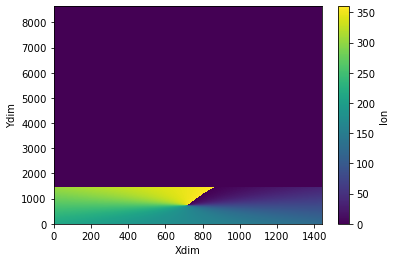

In [56]:
%matplotlib inline
XC.plot()

In [57]:
gridFix

<xarray.Dataset>
Dimensions:       (Xdim: 1440, Ydim: 1440, ncontact: 4, nf: 6, time: 1)
Coordinates:
  * nf            (nf) int32 1 2 3 4 5 6
  * ncontact      (ncontact) int32 1 2 3 4
  * Xdim          (Xdim) float64 -54.97 -54.92 -54.87 ... 34.87 34.92 34.97
  * Ydim          (Ydim) float64 -44.97 -44.92 -44.87 ... 44.87 44.92 44.97
    lons          (nf, Ydim, Xdim) float64 ...
    lats          (nf, Ydim, Xdim) float64 ...
  * time          (time) datetime64[ns] 2012-06-03T06:00:00
Data variables: (12/152)
    cubed_sphere  |S1 ...
    contacts      (nf, ncontact) int32 ...
    orientation   (nf, ncontact) |S5 ...
    anchor        (nf, ncontact, ncontact) int32 ...
    ALBEDO        (time, nf, Ydim, Xdim) float32 ...
    ALBNF         (time, nf, Ydim, Xdim) float32 ...
    ...            ...
    WET1          (time, nf, Ydim, Xdim) float32 ...
    WET2          (time, nf, Ydim, Xdim) float32 ...
    WET3          (time, nf, Ydim, Xdim) float32 ...
    Z0            (time, nf, Ydim, Xdim) float32 ...
    Z0H           (time, nf, Ydim, Xdim) float32 ...
    ZETA_W        (time, nf, Ydim, Xdim) float32 ...
Attributes:
    History:      File written by MAPL_CFIO
    Source:       Heracles-5_3
    Title:        c1440_llc2160_04
    Contact:      http://gmao.gsfc.nasa.gov
    Conventions:  COARDS
    Institution:  NASA Global Modeling and Assimilation Office
    References:   http://gmao.gsfc.nasa.gov
    Comment:      c1440_llc2160_04

So whatever you did with FRLAND, you should do with Xdim and Ydim!

In [58]:
concat_lat = gridFix['lats'].isel(nf=0).values
concat_lon = gridFix['lons'].isel(nf=0).values
for i in range(1,6):
    concat_lat = np.concatenate([concat_lat, gridFix['lats'].isel( nf=i).values],0)
    concat_lon = np.concatenate([concat_lon, gridFix['lons'].isel(nf=i).values],0)


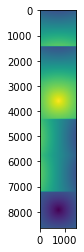

In [59]:
%matplotlib inline
plt.imshow(concat_lat)

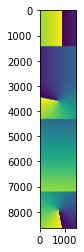

In [60]:
##### %matplotlib inline
plt.imshow(concat_lon)

In [61]:
concat_lon.shape

(8640, 1440)

In [62]:
geos_c1440_lats_lons_2D = xr.Dataset(data_vars = dict(lons = (["Ydim", "Xdim"], concat_lon), lats=(["Ydim","Xdim"], concat_lat),) )

In [63]:
gridds

<xarray.Dataset>
Dimensions:  (Xdim: 1440, Ydim: 8640)
Dimensions without coordinates: Xdim, Ydim
Data variables:
    lat      (Ydim, Xdim) float64 -35.25 -35.28 -35.3 -35.33 ... 0.0 0.0 0.0 0.0
    lon      (Ydim, Xdim) float64 305.0 305.1 305.1 305.2 ... 0.0 0.0 0.0 0.0

In [64]:
geos_c1440_lats_lons_2D

<xarray.Dataset>
Dimensions:  (Xdim: 1440, Ydim: 8640)
Dimensions without coordinates: Xdim, Ydim
Data variables:
    lons     (Ydim, Xdim) float64 305.0 305.1 305.1 305.2 ... 34.9 34.95 35.0
    lats     (Ydim, Xdim) float64 -35.25 -35.28 -35.3 ... -35.34 -35.31 -35.29

In [65]:
geos_c1440_lats_lons_2D.to_netcdf('/nobackup/amondal/NCData/geos_c1440_lats_lons_2D.nc')

I want to debug this properly so I'm going to debug with the constant grid file - I need to test out some code to do this properly:

In [66]:
np.arange(datetime(2020, 1, 22, 0,0), datetime(2020,1,22,1,0), timedelta(hours=1)).astype(datetime)

array([datetime.datetime(2020, 1, 22, 0, 0)], dtype=object)

In [70]:
gsamp

<xarray.Dataset>
Dimensions:    (lat: 8640, lon: 1440, time: 1)
Coordinates:
  * lon        (lon) float64 305.0 305.1 305.1 305.2 ... 34.82 34.87 34.92 34.97
  * lat        (lat) float64 -35.25 -35.2 -35.15 -35.11 ... -35.34 -35.31 -35.29
  * time       (time) datetime64[ns] 2020-01-22
Data variables:
    AREA       (time, lat, lon) float32 ...
    FRLAKE     (time, lat, lon) float32 ...
    FRLAND     (time, lat, lon) float32 ...
    FRLANDICE  (time, lat, lon) float32 ...
    FROCEAN    (time, lat, lon) float32 ...
    PHIS       (time, lat, lon) float32 ...
    SGH        (time, lat, lon) float32 ...
Attributes:
    History:      File written by MAPL_CFIO
    Source:       Heracles-5_3
    Title:        2d,Constant,Time-invariant,Cubed-Sphere on Single-Level,Ass...
    Contact:      http://gmao.gsfc.nasa.gov
    Conventions:  COARDS
    Institution:  NASA Global Modeling and Assimilation Office
    References:   http://gmao.gsfc.nasa.gov
    Comment:      DYAMOND_c1440_llc2160

In [70]:
XC.values.min()

0.0

In [71]:
XC = geos_c1440_lats_lons_2D.lons
YC = geos_c1440_lats_lons_2D.lats

In [72]:
lat_out = np.arange(-90,90+0.0625, 0.0625)
lon_out = np.arange(0, 359.99978637+0.0625, 0.0625)
mapper = LLCMap_nea_split(YC.values, XC.values,lat_out, lon_out, radius=5e3)

In [73]:
mapper

In [74]:
mapper(gridFix['FRLAND'].values)

array([[nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

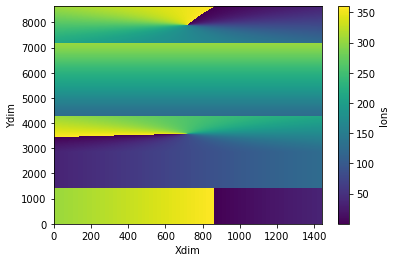

In [75]:
XC.plot()

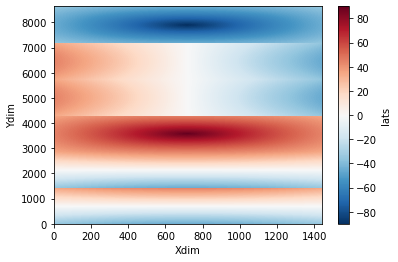

In [76]:
YC.plot()

In [77]:
concat_lat2 = gridFix['lats'].isel(nf=5).values
concat_lon2 = gridFix['lons'].isel(nf=5).values
for i in range(1,6):
    concat_lat2 = np.concatenate([concat_lat2, gridFix['lats'].isel( nf=5-i).values],0)
    concat_lon2 = np.concatenate([concat_lon2, gridFix['lons'].isel(nf=5-i).values],0)

In [78]:
geos_c1440_lats_lons_2D_ATTEMPT2 = xr.Dataset(data_vars = dict(lons = (["Ydim", "Xdim"], concat_lon2), lats=(["Ydim","Xdim"], concat_lat2),) )

In [79]:
XC2 = geos_c1440_lats_lons_2D_ATTEMPT2.lons
YC2 = geos_c1440_lats_lons_2D_ATTEMPT2.lats

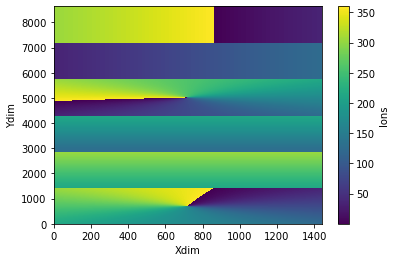

In [80]:
%matplotlib inline 
XC2.plot()

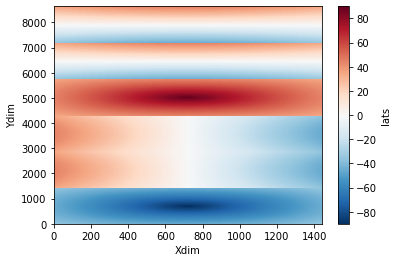

In [81]:
YC2.plot()

In [82]:
lat_out = np.arange(-90,90+0.0625, 0.0625)
lon_out = np.arange(0, 359.99978637+0.0625, 0.0625)
mapper2 = LLCMap_nea_split(YC2.values, XC2.values,lat_out, lon_out, radius=5e3)

In [83]:
mapper(gridFix['FRLAND'].values)

array([[nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [87]:
YC.values

array([[-35.25213623, -35.27659607, -35.30103302, ..., -35.30103302,
        -35.27659607, -35.25213623],
       [-35.2031517 , -35.22759628, -35.25201797, ..., -35.25201797,
        -35.22759628, -35.2031517 ],
       [-35.15416718, -35.1785965 , -35.20300293, ..., -35.20300293,
        -35.1785965 , -35.15416718],
       ...,
       [-35.33784866, -35.36244583, -35.38702011, ..., -35.38702011,
        -35.36244583, -35.33784866],
       [-35.31337738, -35.33792114, -35.36244583, ..., -35.36244583,
        -35.33792114, -35.31337738],
       [-35.28888702, -35.31337738, -35.33784866, ..., -35.33784866,
        -35.31337738, -35.28888702]])

In [91]:
XC.values

array([[305.02597046, 305.07794189, 305.12997437, ...,  34.87002563,
         34.92203903,  34.97402191],
       [305.02597046, 305.07794189, 305.12997437, ...,  34.87002563,
         34.92203903,  34.97402191],
       [305.02597046, 305.07794189, 305.12997437, ...,  34.87002563,
         34.92203903,  34.97402191],
       ...,
       [304.89599609, 304.94796753, 305.        , ...,  35.        ,
         35.0520134 ,  35.10399246],
       [304.94799805, 305.        , 305.05200195, ...,  34.9479866 ,
         35.        ,  35.05197906],
       [305.        , 305.05197144, 305.10397339, ...,  34.89600754,
         34.94801712,  35.        ]])

In [89]:
gridds.lat

<xarray.DataArray 'lat' (Ydim: 8640, Xdim: 1440)>
array([[-35.25213623, -35.27659607, -35.30103302, ..., -35.30103302,
        -35.27659607, -35.25213623],
       [-35.2031517 , -35.22759628, -35.25201797, ..., -35.25201797,
        -35.22759628, -35.2031517 ],
       [-35.15416718, -35.1785965 , -35.20300293, ..., -35.20300293,
        -35.1785965 , -35.15416718],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])
Dimensions without coordinates: Ydim, Xdim

In [94]:
gridds.lon

<xarray.DataArray 'lon' (Ydim: 8640, Xdim: 1440)>
array([[305.02597046, 305.07794189, 305.12997437, ...,  34.87002563,
         34.92203903,  34.97402191],
       [305.02597046, 305.07794189, 305.12997437, ...,  34.87002563,
         34.92203903,  34.97402191],
       [305.02597046, 305.07794189, 305.12997437, ...,  34.87002563,
         34.92203903,  34.97402191],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])
Dimensions without coordinates: Ydim, Xdim

I can try to blindly take the advice of Nina and David and just rotate faces to get what I need:

In [81]:
concat_lat = gridFix['lats'].isel(nf=0).values
concat_lon = gridFix['lons'].isel(nf=0).values
for i in range(1,6):
    concat_lat = np.concatenate([concat_lat, gridFix['lats'].isel( nf=i).values],0)
    concat_lon = np.concatenate([concat_lon, gridFix['lons'].isel(nf=i).values],0)

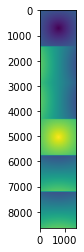

In [62]:
%matplotlib inline 
plt.imshow(concat_lat)

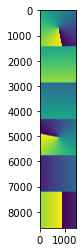

In [63]:
%matplotlib inline 
plt.imshow(concat_lon)

In [48]:
concat_lat.shape

(1440, 8640)

In [49]:
geos_c1440_lats_lons_2D = xr.Dataset(data_vars = dict(lons = (["Ydim", "Xdim"], concat_lon), lats=(["Ydim","Xdim"], concat_lat),) )

In [50]:
geos_c1440_lats_lons_2D

<xarray.Dataset>
Dimensions:  (Xdim: 8640, Ydim: 1440)
Dimensions without coordinates: Xdim, Ydim
Data variables:
    lons     (Ydim, Xdim) float64 305.0 305.1 305.1 305.2 ... 34.9 34.95 35.0
    lats     (Ydim, Xdim) float64 -35.25 -35.28 -35.3 ... -35.34 -35.31 -35.29

In [71]:
fland = mapper2(gsamp['FRLAND'].values)

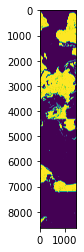

In [78]:
plt.imshow(gsamp['FRLAND'].isel(time=0).values)

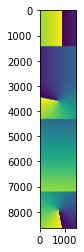

In [82]:
plt.imshow(concat_lon)

In [72]:
fland.shape

(2881, 5760)

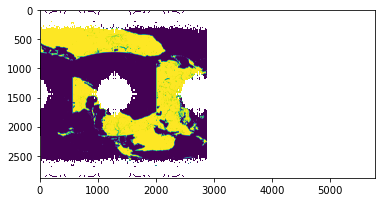

In [73]:
%matplotlib inline
plt.imshow(fland)

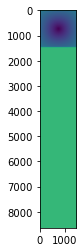

In [59]:
plt.imshow(gridds.lat.values)

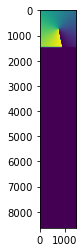

In [64]:
plt.imshow(gridds.lon.values)

In [93]:
lat_out = np.arange(-90,90+0.0625, 0.0625)
lon_out = np.arange(-180,180+0.0625, 0.0625)
mapper2 = LLCMap_nea_split(concat_lat, concat_lon,lat_out, lon_out, radius=10e3)

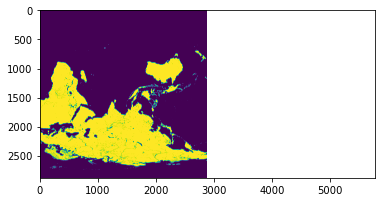

In [94]:
%matplotlib inline
fland = mapper2(gsamp['FRLAND'].values)
plt.imshow(fland)

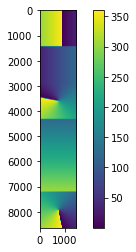

In [92]:
plt.imshow(concat_lon)
plt.colorbar()

In [96]:
concat_lon_transform = np.where(concat_lon>180, concat_lon - 360, concat_lon)

In [97]:
lat_out = np.arange(-90,90+0.0625, 0.0625)
lon_out = np.arange(-180,180+0.0625, 0.0625)
mapper2 = LLCMap_nea_split(concat_lat, concat_lon_transform,lat_out, lon_out, radius=10e3)

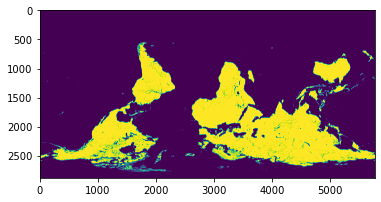

In [98]:
%matplotlib inline
fland = mapper2(gsamp['FRLAND'].values)
plt.imshow(fland)

In [109]:
lat_out = np.arange(-90,90+0.0625, 0.0625)
lon_out = np.arange(-180,180+0.0625, 0.0625)
mapper2 = LLCMap_bi_split(concat_lat, concat_lon_transform,lat_out, lon_out, radius=16e3)

/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/pyproj/crs/crs.py:1216: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:361: RuntimeWarning: invalid value encountered in true_divide
  g__ = ((out_y - y_1 - y_21 * f__) /


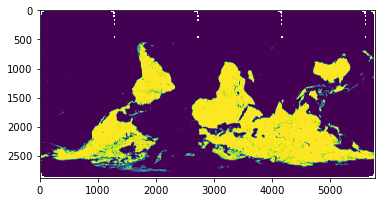

In [110]:
###### %matplotlib inline
fland = mapper2(gsamp['FRLAND'].values)
plt.imshow(fland)

In [111]:
geos_c1440_lats_lons_2D = xr.Dataset(data_vars = dict(lons = (["Ydim", "Xdim"], concat_lon_transform), lats=(["Ydim","Xdim"], concat_lat),) )

In [112]:
geos_c1440_lats_lons_2D

<xarray.Dataset>
Dimensions:  (Xdim: 1440, Ydim: 8640)
Dimensions without coordinates: Xdim, Ydim
Data variables:
    lons     (Ydim, Xdim) float64 -54.97 -54.92 -54.87 ... 34.9 34.95 35.0
    lats     (Ydim, Xdim) float64 -35.25 -35.28 -35.3 ... -35.34 -35.31 -35.29

In [138]:
xc = geos_c1440_lats_lons_2D.lons

In [139]:
xc = xr.where(xc >= 180, XC - 360, XC)

In [140]:
xc.values

array([[215.        , 214.94801331, 214.89599609, ..., 125.10398865,
        125.05197906, 125.        ],
       [215.05197144, 215.        , 214.94798279, ..., 125.05200958,
        125.        , 124.94801331],
       [215.10398865, 215.05200195, 215.        , ..., 125.        ,
        124.94798279, 124.89600372],
       ...,
       [305.02597046, 305.07794189, 305.12997437, ...,  34.87002563,
         34.92203903,  34.97402191],
       [305.02597046, 305.07794189, 305.12997437, ...,  34.87002563,
         34.92203903,  34.97402191],
       [305.02597046, 305.07794189, 305.12997437, ...,  34.87002563,
         34.92203903,  34.97402191]])

In [114]:
lat_out = np.arange(-90,90+0.0625, 0.0625)
lon_out = np.arange(-180,180+0.0625, 0.0625)
mapper2 = LLCMap_nea_split(geos_c1440_lats_lons_2D.lats.values,geos_c1440_lats_lons_2D.lons.values,lat_out, lon_out, radius=10e3)

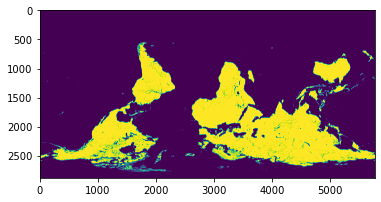

In [115]:
###### %matplotlib inline
fland = mapper2(gsamp['FRLAND'].values)
plt.imshow(fland)

In [116]:
geos_c1440_lats_lons_2D.to_netcdf("/nobackup/amondal/NCData/geos_c1440_lats_lons_2D.nc")

In [117]:
yc = geos_c1440_lats_lons_2D.lats

In [118]:
yc

<xarray.DataArray 'lats' (Ydim: 8640, Xdim: 1440)>
array([[-35.25213623, -35.27659607, -35.30103302, ..., -35.30103302,
        -35.27659607, -35.25213623],
       [-35.2031517 , -35.22759628, -35.25201797, ..., -35.25201797,
        -35.22759628, -35.2031517 ],
       [-35.15416718, -35.1785965 , -35.20300293, ..., -35.20300293,
        -35.1785965 , -35.15416718],
       ...,
       [-35.33784866, -35.36244583, -35.38702011, ..., -35.38702011,
        -35.36244583, -35.33784866],
       [-35.31337738, -35.33792114, -35.36244583, ..., -35.36244583,
        -35.33792114, -35.31337738],
       [-35.28888702, -35.31337738, -35.33784866, ..., -35.33784866,
        -35.31337738, -35.28888702]])
Dimensions without coordinates: Ydim, Xdim

In [179]:
FRLAND = xr.open_dataset('/nobackup/amondal/NCData/20210928_GEOS_tend_test_LEV/FRLAND/FRLAND_2020012200.nc')

In [180]:
FRLAND.lon

<xarray.DataArray 'lon' (lon: 5745)>
array([0.000000e+00, 6.250000e-02, 1.250000e-01, ..., 3.588750e+02,
       3.589375e+02, 3.590000e+02])
Coordinates:
  * lon      (lon) float64 0.0 0.0625 0.125 0.1875 ... 358.8 358.9 358.9 359.0

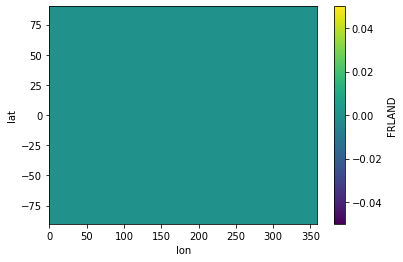

In [181]:
%matplotlib inline
FRLAND.FRLAND.plot()

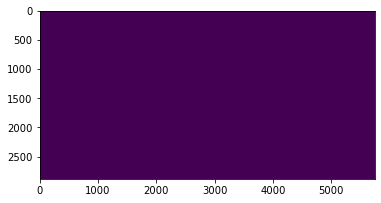

In [172]:
plt.imshow(FRLAND.FRLAND.values)

In [128]:
dtdtdyn = xr.open_dataset('/nobackup/amondal/NCData/20210928_GEOS_tend_test_LEV/DTDTDYN/DTDTDYN_2020030109.nc')

In [129]:
dtdtdyn

<xarray.Dataset>
Dimensions:  (lat: 17, lev: 19, lon: 17)
Coordinates:
  * lev      (lev) float64 54.0 55.0 56.0 57.0 58.0 ... 68.0 69.0 70.0 71.0 72.0
  * lat      (lat) float64 34.0 34.06 34.12 34.19 ... 34.81 34.88 34.94 35.0
  * lon      (lon) float64 -65.0 -64.94 -64.88 -64.81 ... -64.12 -64.06 -64.0
Data variables:
    DTDTDYN  (lev, lat, lon) float64 ...

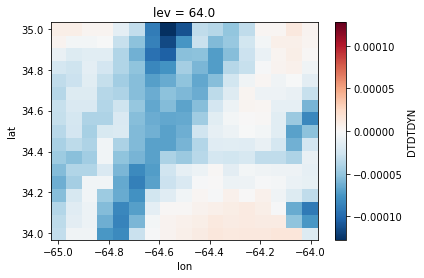

In [137]:
dtdtdyn.DTDTDYN.isel(lev=10).plot()

In [ ]:
#Let me open up one of the netcdf4 files that are in Dimitris' directories:
diro = "/nobackupp11/dmenemen/DYAMOND/c1440_llc2160/holding/geosgcm_tend/"
file = "DYAMOND_c1440_llc2160.geosgcm_tend.20200120_0900z.nc4"
gsamp = xr.open_dataset(diro+file)

In [145]:
GEOS_gridfile = "/nobackup/amondal/NCData/geos_c1440_lats_lons_2D.nc"
gridds = xr.open_dataset(GEOS_gridfile)
XC = gridds.lons
XC = xr.where(XC>=180, XC- 360, XC)
YC = gridds.lats
mapper = LLCMap_nea_split(YC.values, XC.values, lat_out, lon_out, radius=10e3)

In [151]:
YC.values

array([[-35.25213623, -35.27659607, -35.30103302, ..., -35.30103302,
        -35.27659607, -35.25213623],
       [-35.2031517 , -35.22759628, -35.25201797, ..., -35.25201797,
        -35.22759628, -35.2031517 ],
       [-35.15416718, -35.1785965 , -35.20300293, ..., -35.20300293,
        -35.1785965 , -35.15416718],
       ...,
       [-35.33784866, -35.36244583, -35.38702011, ..., -35.38702011,
        -35.36244583, -35.33784866],
       [-35.31337738, -35.33792114, -35.36244583, ..., -35.36244583,
        -35.33792114, -35.31337738],
       [-35.28888702, -35.31337738, -35.33784866, ..., -35.33784866,
        -35.31337738, -35.28888702]])

In [154]:
np.array_equal(YC.values, concat_lat)

True

In [152]:
concat_lon_transform

array([[-54.97402954, -54.92205811, -54.87002563, ...,  34.87002563,
         34.92203903,  34.97402191],
       [-54.97402954, -54.92205811, -54.87002563, ...,  34.87002563,
         34.92203903,  34.97402191],
       [-54.97402954, -54.92205811, -54.87002563, ...,  34.87002563,
         34.92203903,  34.97402191],
       ...,
       [-55.10400391, -55.05203247, -55.        , ...,  35.        ,
         35.0520134 ,  35.10399246],
       [-55.05200195, -55.        , -54.94799805, ...,  34.9479866 ,
         35.        ,  35.05197906],
       [-55.        , -54.94802856, -54.89602661, ...,  34.89600754,
         34.94801712,  35.        ]])

In [148]:
lat_out

array([-90.    , -89.9375, -89.875 , ...,  89.875 ,  89.9375,  90.    ])

In [149]:
lon_out

array([-180.    , -179.9375, -179.875 , ...,  179.875 ,  179.9375,
        180.    ])

In [159]:
d = mapper(gsamp['FRLAND'].mean('time').values)

In [160]:
d

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [157]:
#Let me open up one of the netcdf4 files that are in Dimitris' directories:
diro = "/nobackupp11/dmenemen/DYAMOND/c1440_llc2160/holding/const_2d_asm_Mx/"
file = "DYAMOND_c1440_llc2160.const_2d_asm_Mx.20200122_0000z.nc4"
gsamp = xr.open_dataset(diro+file)


<xarray.DataArray 'FRLAND' (time: 1, lat: 8640, lon: 1440)>
[12441600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 305.0 305.1 305.1 305.2 ... 34.82 34.87 34.92 34.97
  * lat      (lat) float64 -35.25 -35.2 -35.15 -35.11 ... -35.34 -35.31 -35.29
  * time     (time) datetime64[ns] 2020-01-22
Attributes:
    long_name:       fraction_of_land
    units:           1
    fmissing_value:  1000000000000000.0
    standard_name:   fraction_of_land
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

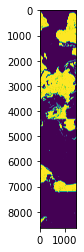

In [164]:
plt.imshow(gsamp['FRLAND'].isel(time=0).values)

In [173]:
d = mapper(gsamp['FRLAND'].mean('time').values)

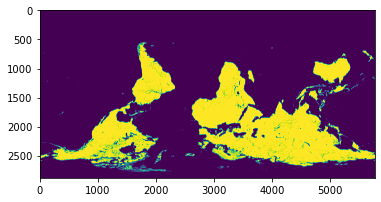

In [174]:
plt.imshow(d)

In [183]:
gsamp['FRLAND'].lon

<xarray.DataArray 'lon' (lon: 1440)>
array([305.02597 , 305.077942, 305.129974, ...,  34.870026,  34.922039,
        34.974022])
Coordinates:
  * lon      (lon) float64 305.0 305.1 305.1 305.2 ... 34.82 34.87 34.92 34.97
Attributes:
    long_name:  longitude
    units:      degrees_east

In [184]:
output = xr.DataArray(np.zeros((lat_out.shape[0], lon_out.shape[0] )), coords=[lat_out,lon_out], dims=['lat','lon'])

In [185]:
output

<xarray.DataArray (lat: 2881, lon: 5761)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.94 -89.88 -89.81 ... 89.81 89.88 89.94 90.0
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0

In [186]:
print(gsamp['FRLAND'])

<xarray.DataArray 'FRLAND' (time: 1, lat: 8640, lon: 1440)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 305.0 305.1 305.1 305.2 ... 34.82 34.87 34.92 34.97
  * lat      (lat) float64 -35.25 -35.2 -35.15 -35.11 ... -35.34 -35.31 -35.29
  * time     (time) datetime64[ns] 2020-01-22
Attributes:
    long_name:       fraction_of_land
    units:           1
    fmissing_value:  1000000000000000.0
    standard_name:   fraction_of_land
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]


In [14]:
dir = '/nobackup/amondal/NCData/20210928_GEOS_tend_test_LEV/DTDTDYN'
file = '/DTDTDYN_2020030109.nc'
test = xr.open_dataset(dir+file)

In [15]:
test

<xarray.Dataset>
Dimensions:  (lats: 17, levs: 6, lons: 17)
Coordinates:
  * lats     (lats) float64 34.0 34.06 34.12 34.19 ... 34.81 34.88 34.94 35.0
  * lons     (lons) float64 -65.0 -64.94 -64.88 -64.81 ... -64.12 -64.06 -64.0
  * levs     (levs) int64 50 51 52 53 54 55
Data variables:
    DTDTDYN  (lats, lons, levs) float64 ...

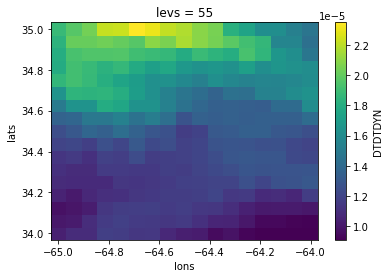

In [21]:
%matplotlib inline
test.DTDTDYN.isel(levs=5).plot()

In [31]:
dir = '/nobackup/amondal/NCData/20210928_GEOS_tend_test_LEV_LAND/FRLAND'
file = '/FRLAND_2020012200.nc'
fland = xr.open_dataset(dir+file)

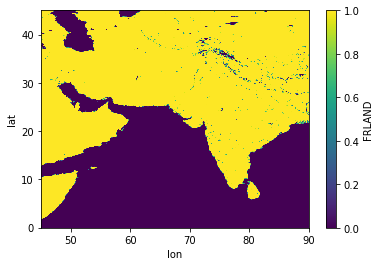

In [32]:
fland.FRLAND.plot()